In [2]:
import numpy as np
import cv2
import os, sys
import matplotlib.pyplot as plt

In [10]:
DPATH = '/home/ubuntu/datasets/tissue'
HPATH = '%s/healthy' % DPATH
CPATH = '%s/cancers' % DPATH

healthy_samples = os.listdir(HPATH)
print(len(healthy_samples))

cancer_samples = [fl for fl in os.listdir(CPATH) if '.npy' in fl]
cancer_masks = [fl for fl in os.listdir(CPATH) if '.jpg' in fl]
print(len(cancer_samples))
print('%d masks' % len(cancer_masks))

278564
101714
101714 masks


In [12]:
bycases = {}

def strip_sid(raw):
    sid = '_'.join(raw.split('_')[:-2])
    return sid
for samp in cancer_samples:
    sid = strip_sid(samp)
    if sid not in bycases: bycases[sid] = []
    bycases[sid].append(samp)

print('%d unique cases' % len(bycases))

2953 unique cases


In [33]:
maxsamp = 3
all_areas = []
for ii, (sid, samples) in enumerate(bycases.items()):
    areas = []
    for samp in samples[:maxsamp]:
        mpath = '%s/%s.jpg' % (CPATH, samp.replace('.npy', '')) 
        mask = cv2.imread(mpath, 0)
        area = np.sum(mask > 0)
        try:
            assert area <= mask.shape[0] * mask.shape[1]
        except:
            print(area, mask.shape)
            assert False
        areas.append(area)
    all_areas.append(np.mean(areas))
    
    if ii % 20 == 0:
        sys.stdout.write('%d/%d        \r' % (ii, len(bycases)))
        sys.stdout.flush()
    
print('%.2f avg area' % np.mean(all_areas))  

58868.95 avg area


In [34]:
print('%.2f avg area' % np.mean(all_areas))
print('%.2f min area' % np.min(all_areas))
print('%.2f max area' % np.max(all_areas))

58868.95 avg area
1301.00 min area
147456.00 max area


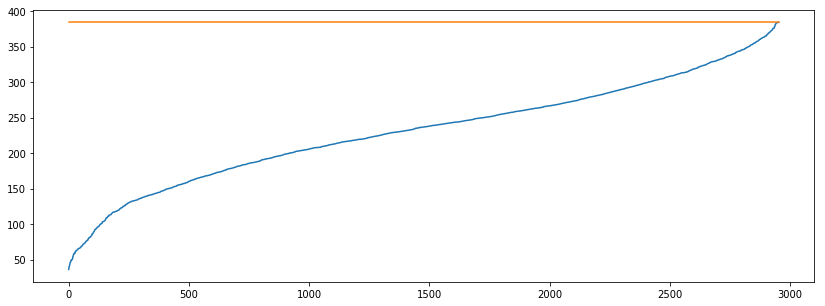

In [38]:
all_areas = sorted(all_areas)
plt.figure(figsize=(14, 5))
plt.plot(np.sqrt(all_areas))
plt.plot([0, len(all_areas)], [384, 384])
# plt.bar(list(range(len(dist))), dist)
plt.show()
plt.close()